In [164]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
#%matplotlib widget, remove below if used
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [165]:
def extract_in_out_movement(df,fn,detector="SPIN",axis="Y",avg_rng=1):
    freq=np.mean(df.CANT_FREQ)
    fs=np.mean(df.FS)
    factor = int(fs/(2*freq))
    start = int(factor/2)
    #print(start)
    end= len(df["%s_SUM_diff" %detector][fn])-start
    #print(end)
    data_x = np.zeros(factor)
    data_x2 = np.zeros(factor)
    data_y = np.zeros(factor)
    data_y2 = np.zeros(factor)
    i=0
    for k in np.arange(start,end,factor):
        i+=1
        averaged_series = pd.Series(df["%s_SUM_diff" %detector][fn]).ewm(span=avg_rng,adjust=True).mean()
        data_y_temp = averaged_series[k:k+factor]/averaged_series.mean()#df["QPD_SUM_diff"][0][1300:-1400] # give y data 
        data_x_temp = df["CANT_POS_%s_cal" %axis][fn][k:k+factor]# give x data
        if(np.sum(data_y_temp)<0): data_y_temp = -data_y_temp
        if((i % 2) == 0):
            data_y = np.add(data_y,np.array(data_y_temp))
            data_x = np.add(data_x,data_x_temp)
        else:
            data_y2 = np.add(data_y2,np.array(data_y_temp))  
            data_x2 = np.add(data_x2,data_x_temp)
    data_x = data_x/(0.5*(i-1)) # factor automatic
    data_x2 = data_x2/(0.5*(i+1)) # factor automatic +-1
    data_y = data_y
    data_y2 = data_y2
    #plt.plot(data_x,data_y)
    return data_y,data_y2,data_x,data_x2        

In [166]:
def prepare_profile_data(files):
    # spin data structure changed to two spin readouts therefore spin_data -> spin_data[0]
    # prepare the data into a data frame using the calibration Akio has performed
    df = pd.DataFrame()
    spin_list = [] # a list for the spin_sum
    qsum_list = [] # a list for the quad_sum 
    cant_pos_list_x, cant_pos_list_y, cant_pos_list_z = [[] for  x in range(3)] # save the positions of the cantielever
    spin_length = files[0].spin_data
    spin_down_size_factor = len(spin_length)/len(files[0].xyz[0]) # 10 for normal operation, but can be different
    
    for i in tqdm(range(len(files))):
        spin = np.zeros(len(files[0].xyz[0]))
        spin_temp = files[i].spin_data
        spin_list.append(spin_temp)
        #print(spin_list)

        qsum_list.append(files[i].quad_sum)
        cant_pos_list_x.append(files[i].cant_pos[0])
        cant_pos_list_y.append(files[i].cant_pos[1])
        cant_pos_list_z.append(files[i].cant_pos[2])
    df["QPD_SUM"] = qsum_list
    df["SPIN_SUM"] = spin_list 
    df["CANT_POS_X"] = cant_pos_list_x
    df["CANT_POS_Y"] = cant_pos_list_y
    df["CANT_POS_Z"] = cant_pos_list_z
    df["CANT_FREQ"] = files[0].cant_freq
    df["FS"] = files[0].fsamp
    
    # use calibration
    ## applies calibration assuming x and y have the same
    df["CANT_POS_X_cal"] = df["CANT_POS_X"].apply(lambda element: voltage_to_x_position(element))  
    df["CANT_POS_Y_cal"] = df["CANT_POS_Y"].apply(lambda element: voltage_to_x_position(element)) 
    df["CANT_POS_Z_cal"] = df["CANT_POS_Z"].apply(lambda element: voltage_to_z_position(element))
    
    
    # differentiate the power to get dP/dx plots
    df["QPD_SUM_diff"] = df["QPD_SUM"].apply(lambda element: np.diff(element)) # 
    df["SPIN_SUM_diff"] = df["SPIN_SUM"].apply(lambda element: np.diff(element)) # 
    
    return df

In [248]:
def extract_waist_data(df,up_or_low = "up",axis="Y",detector="SPIN",avg_rng=10,sub_sample=False,plot=False,logscale=True,save=True):
    sigma_list,mean_err_list,mean_list,chi2_list,fit_list = [[] for x in range(5)]
    if(sub_sample==True):length=1
    else: length=len(df)
    for j in tqdm(np.arange(0,length,1)):
        data_y,data_y2,data_x,data_x2 = extract_in_out_movement(df,j,detector,axis,avg_rng=1)
        if(up_or_low=="up"):m = fit_dP_dx(data_x,data_y,plot=plot)
        if(up_or_low=="low"):m = fit_dP_dx(data_x2,data_y2,plot=plot)
        sigma_list.append(m.values["sigma"])
        mean_err_list.append(m.errors["mean"])
        mean_list.append(m.values["mean"])
        chi2_list.append(m.fval/(len(data_x)-3))
        fit_list.append(m)
    if(save==True):
        if(axis=="X"):fname=fname_x
        if(axis=="Y"):fname=fname_y
        np.save(folder+fname+"_sigma_list.npy", sigma_list)
        np.save(folder+fname+"_mean_list.npy", mean_list)
        np.save(folder+fname+"_chi2_list.npy", chi2_list)
    print(np.sum(data_y),m.values["area"],m.values["mean"],m.values["sigma"])
    return sigma_list,mean_err_list, mean_list, chi2_list,fit_list

In [266]:
def fit_dP_dx(data_x,data_y,data_y_error=None,plot=False,logscale=False):
    if(data_y_error==None): data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty
    def chisquare_gaussian_beam(area,mean,sigma,constant):
        return chisquare_1d(function=gaussian_beam,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    arg_maxy = np.array(data_x)[np.argmax(np.array(data_y))]
    #print(maxy,np.sum(data_y))
    #plt.plot(data_x,data_y)
    #plt.show()
    try:
        m=Minuit(chisquare_gaussian_beam, 
                 area = 20000, # set start parameter
                 #limit_area= (np.sum(data_y)/200,np.sum(data_y)), # if you want to limit things
                 #fix_area = "False", # you can also fix it
                 mean = arg_maxy,
                 fix_mean = "False",
                 limit_mean = (arg_maxy-25, arg_maxy+25),
                 sigma = 6,
                 constant = 0,
                 fix_constant="True",
                 errordef = 1,
                 print_level=0,
                 pedantic=False)
        #print('Now proceed with the fit.')
        m.migrad()
        #print()
        #m.minos()#, if you need fancy mapping
        chisquare=m.fval
    except:print("Fit did not converge")   
    #print(chisquare)
    #print(m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"])
    if(plot==True):
        plt.plot(data_x,data_y/np.mean(data_y))
        plt.plot(data_x,gaussian_beam(data_x,params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]])/np.mean(data_y))
        if(logscale==True):plt.yscale("log")
        #plt.xlim(450,480)
        plt.show()
    return m

In [267]:
folder =  r"/home/data_transfer/data_from_windows/20200320/Bead1/Shaking/"

fname_1="BeamProfiling_X_"
fname_2="BeamProfiling_Y_"


files_1 = load_dir(folder, file_prefix = fname_1, max_file=100)
files_2 = load_dir(folder, file_prefix = fname_2, max_file=100)


 17%|█▋        | 1/6 [00:00<00:00,  8.80it/s]

No seismometer data
No z_set data
No seismometer data
No z_set data
No seismometer data
No z_set data


 67%|██████▋   | 4/6 [00:00<00:00,  8.79it/s]

No seismometer data
No z_set data
No seismometer data
No z_set data
No seismometer data
No z_set data


 33%|███▎      | 2/6 [00:00<00:00, 13.42it/s]

6  files in folder
6  files loaded
No seismometer data
No z_set data
No seismometer data
No z_set data


 67%|██████▋   | 4/6 [00:00<00:00, 12.66it/s]

No seismometer data
No z_set data
No seismometer data
No z_set data
No seismometer data
No z_set data


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]

No seismometer data
No z_set data
6  files in folder
6  files loaded


In [268]:
df_1 = prepare_profile_data(files_1)


100%|██████████| 6/6 [00:00<00:00, 10369.11it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

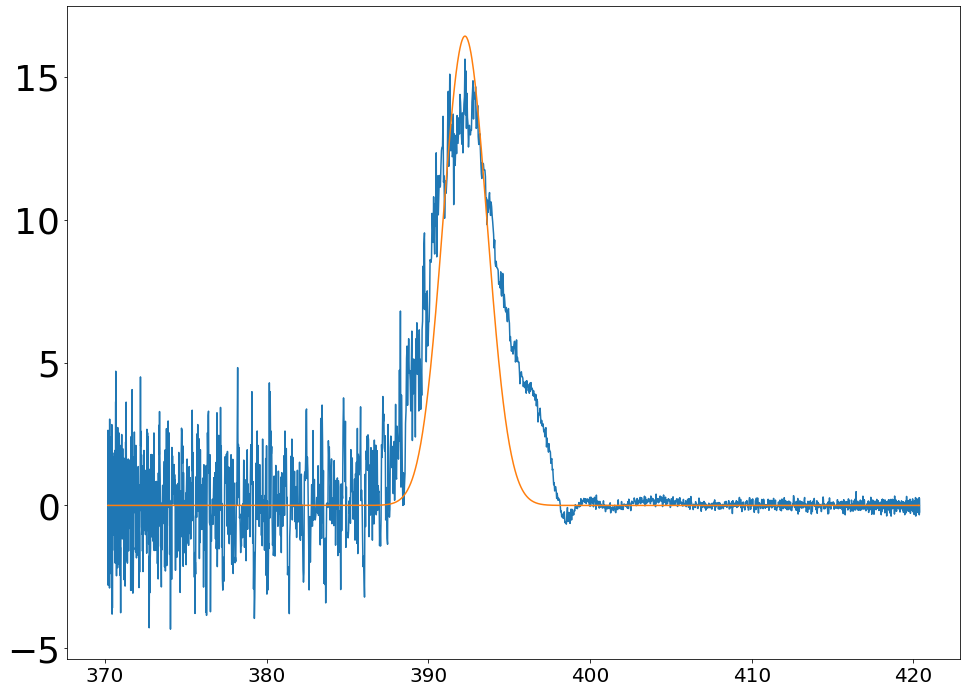

 17%|█▋        | 1/6 [00:00<00:01,  4.91it/s]

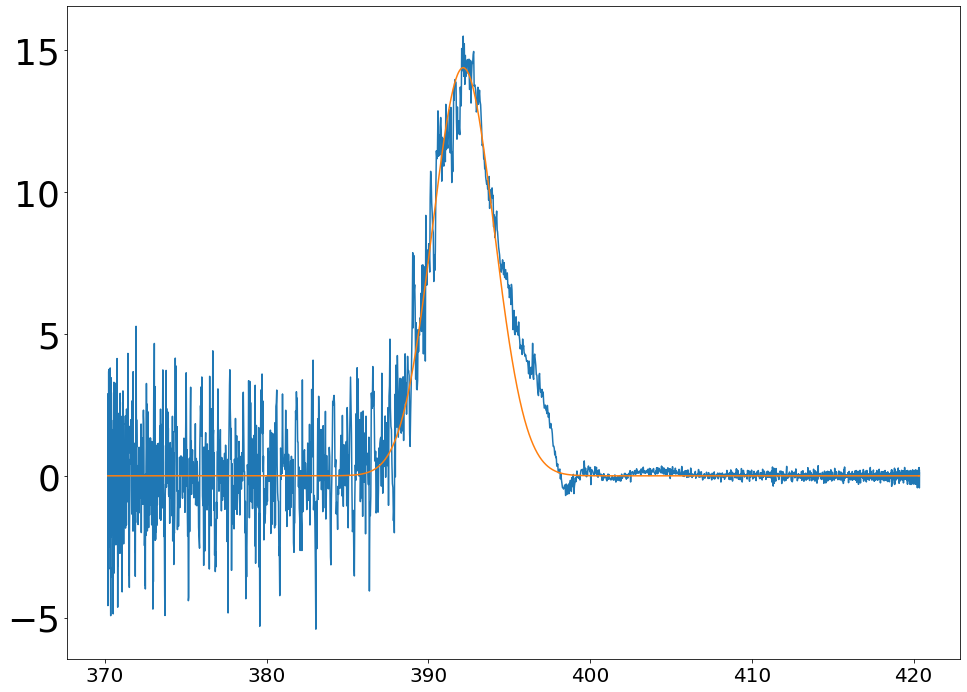

 33%|███▎      | 2/6 [00:00<00:00,  4.95it/s]

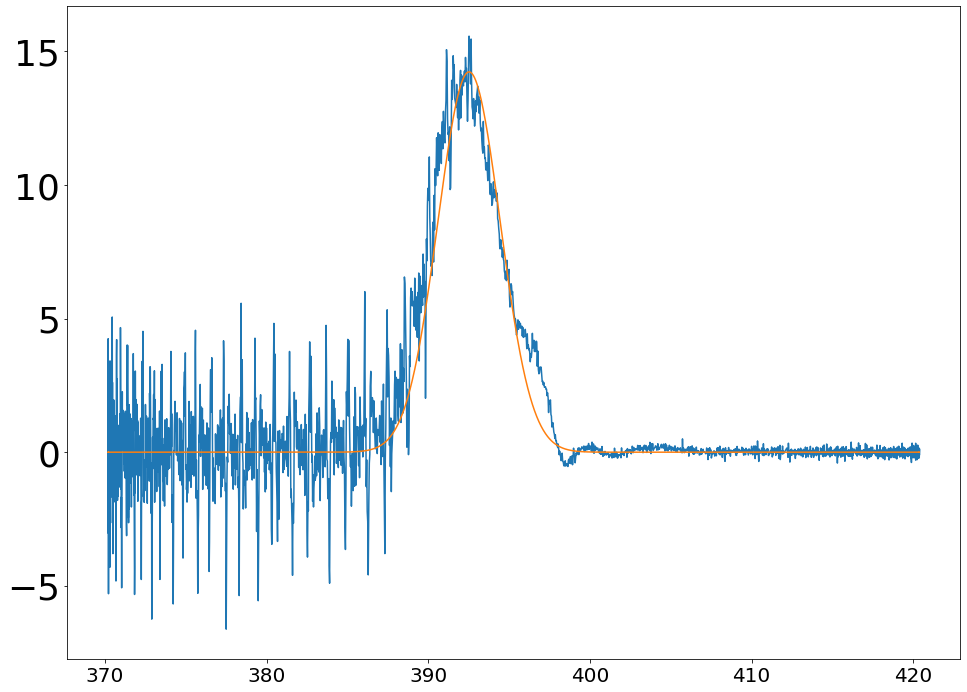

 50%|█████     | 3/6 [00:00<00:00,  4.96it/s]

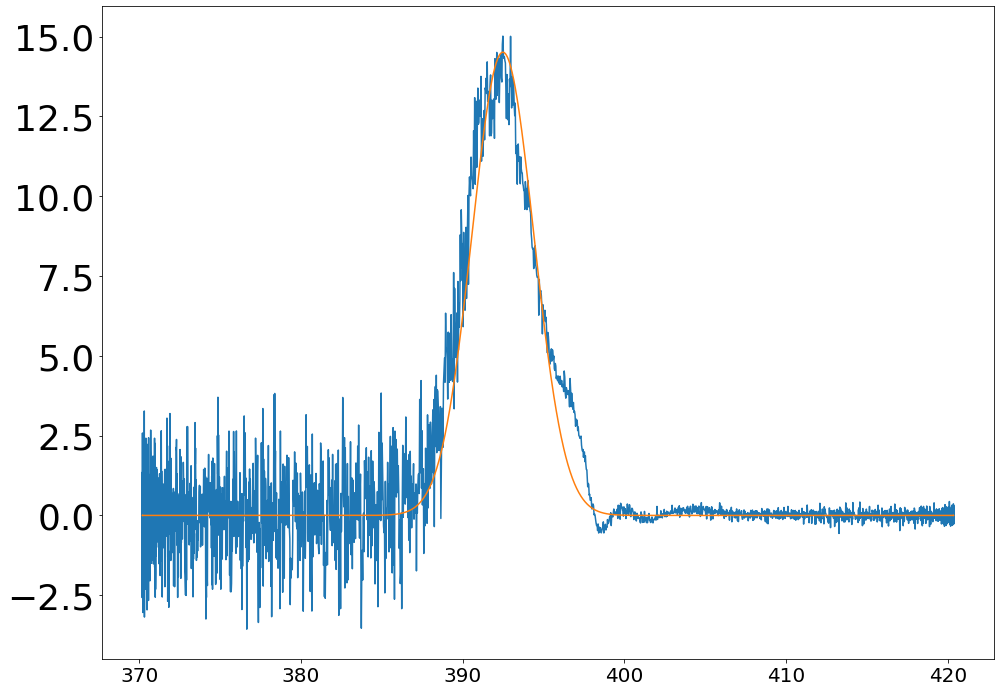

 67%|██████▋   | 4/6 [00:00<00:00,  4.96it/s]

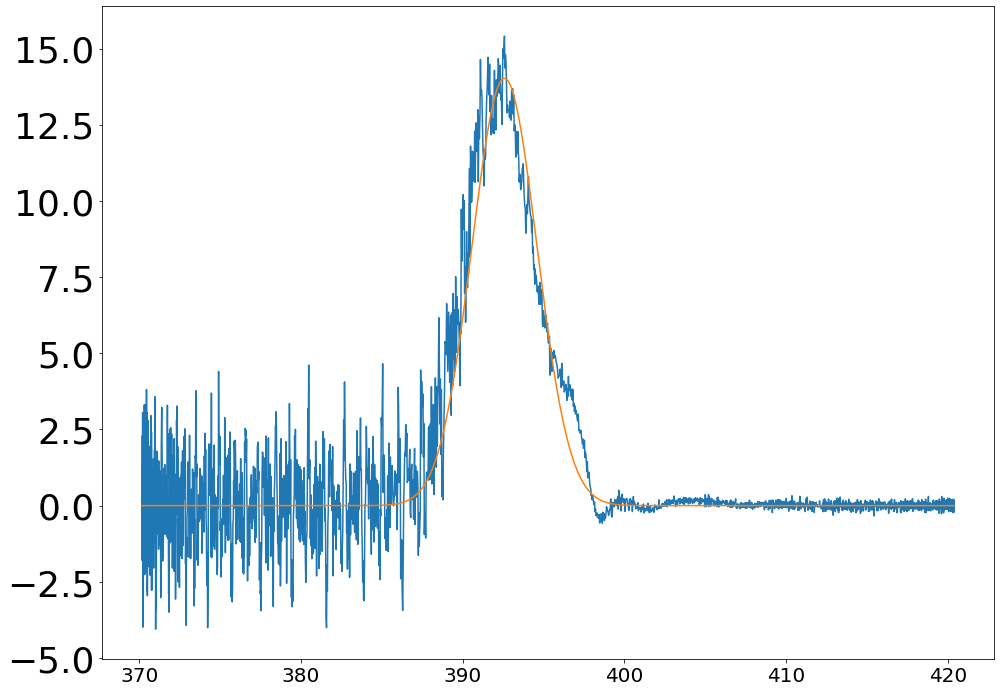

 83%|████████▎ | 5/6 [00:01<00:00,  4.96it/s]

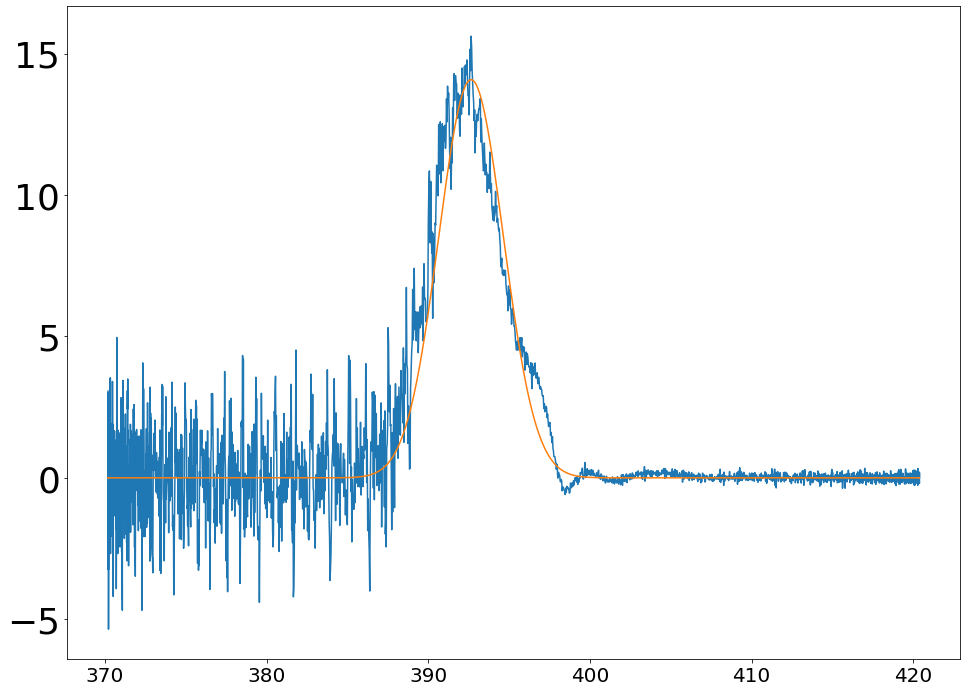

100%|██████████| 6/6 [00:01<00:00,  5.09it/s]

108731660.91025454 612282.2578668381 392.64418822892725 3.9961216330282934


In [276]:
avg_rng=1
up_or_low="up"
x = extract_waist_data(df_1,up_or_low=up_or_low,axis="X",detector="QPD",avg_rng=avg_rng,sub_sample=False,plot=True,logscale=False,save=False)


In [277]:
print(x[2])

[392.26262815695674, 392.1528767965506, 392.51651084159, 392.48151001590026, 392.57969595842275, 392.64418822892725]


In [278]:
np.mean(x[2][1:])

392.4749563682782

In [275]:
np.std(x[2][3:])

0.19311973640544186

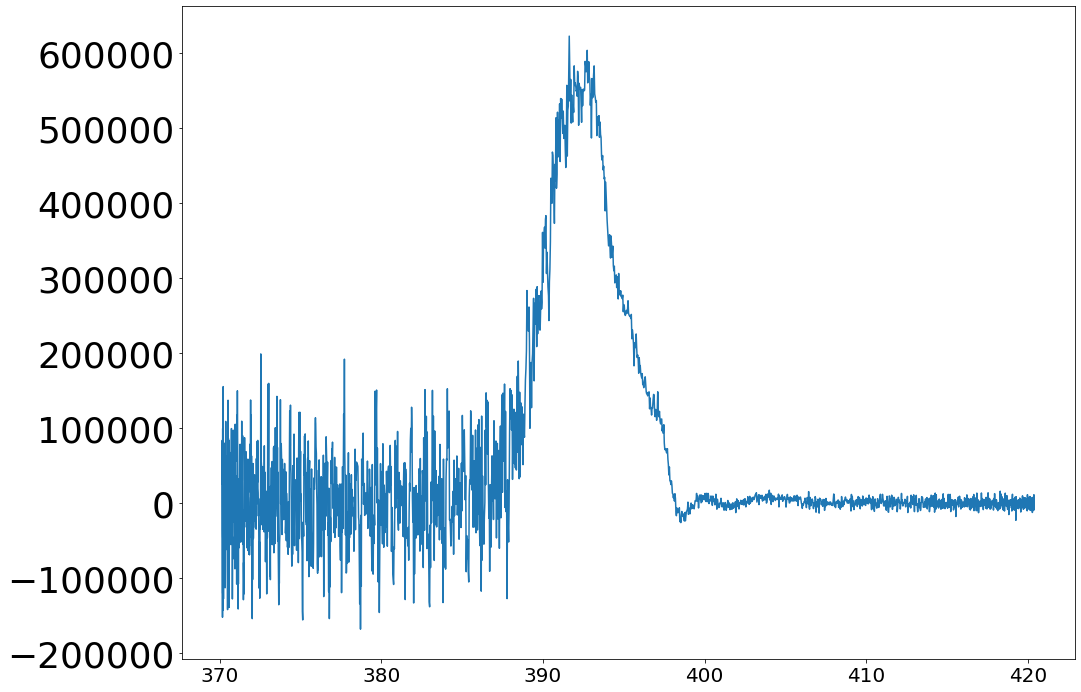

In [204]:
plt.plot(x,y)

572208.7765381656 392.5553669468108 4.077096287066704 0.0


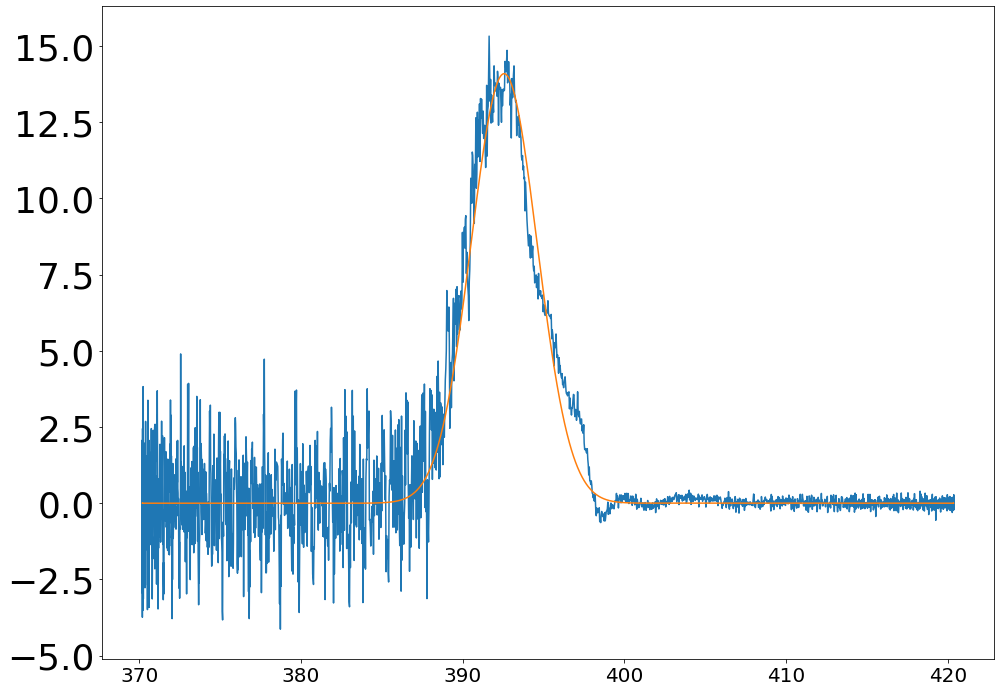

In [205]:
def chisquare_gaussian_beam(area,mean,sigma,constant):
    return chisquare_1d(function=gaussian_beam,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
data_x=x
data_y=y
data_y_error = np.sqrt(np.abs(y))+0.01
arg_maxy = np.array(data_x)[np.argmax(np.array(data_y))]
#print(maxy,np.sum(data_y))
#plt.plot(data_x,data_y)
#plt.show()
m=Minuit(chisquare_gaussian_beam, 
         area = 2000000, # set start parameter
         #limit_area= (np.sum(data_y)/200,np.sum(data_y)), # if you want to limit things
         #fix_area = "False", # you can also fix it
         mean = arg_maxy,
         #fix_mean = "True",
         limit_mean = (arg_maxy-20, arg_maxy+20),
         sigma = 4,
         constant = 0,
         fix_constant="True",
         errordef = 1,
         print_level=0,
         pedantic=False)
#print('Now proceed with the fit.')
m.migrad()
#print()
#m.minos()#, if you need fancy mapping
chisquare=m.fval
#print(chisquare)
print(m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"])
plt.plot(data_x,data_y/np.mean(data_y))
plt.plot(data_x,gaussian_beam(data_x,params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]])/np.mean(data_y))
#plt.xlim(450,480)
plt.show()

In [281]:
df_2 = prepare_profile_data(files_2)


100%|██████████| 6/6 [00:00<00:00, 8927.22it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

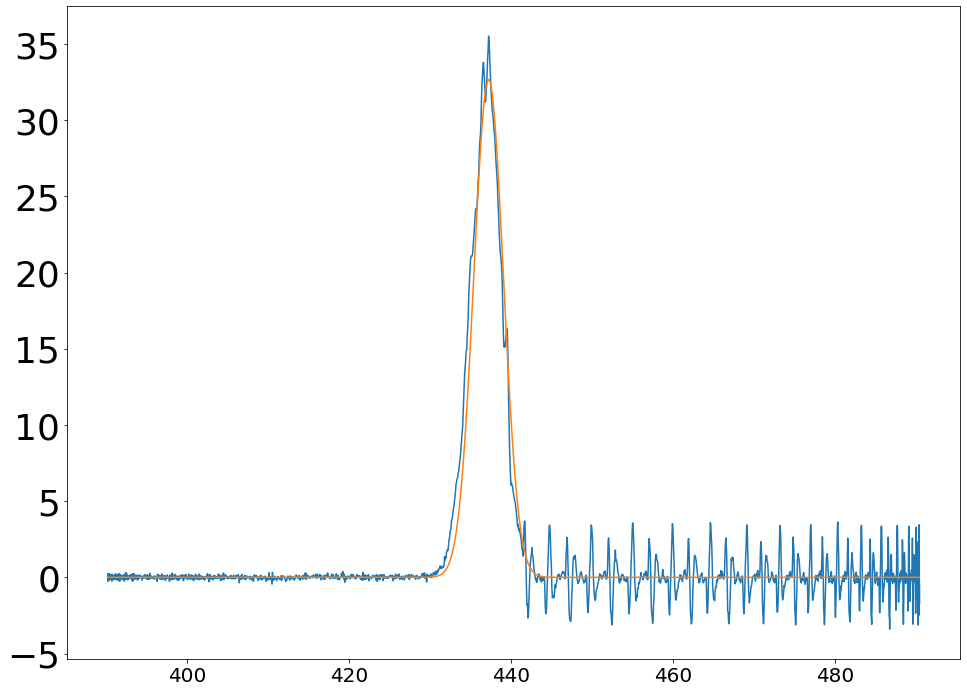

 17%|█▋        | 1/6 [00:00<00:01,  4.94it/s]

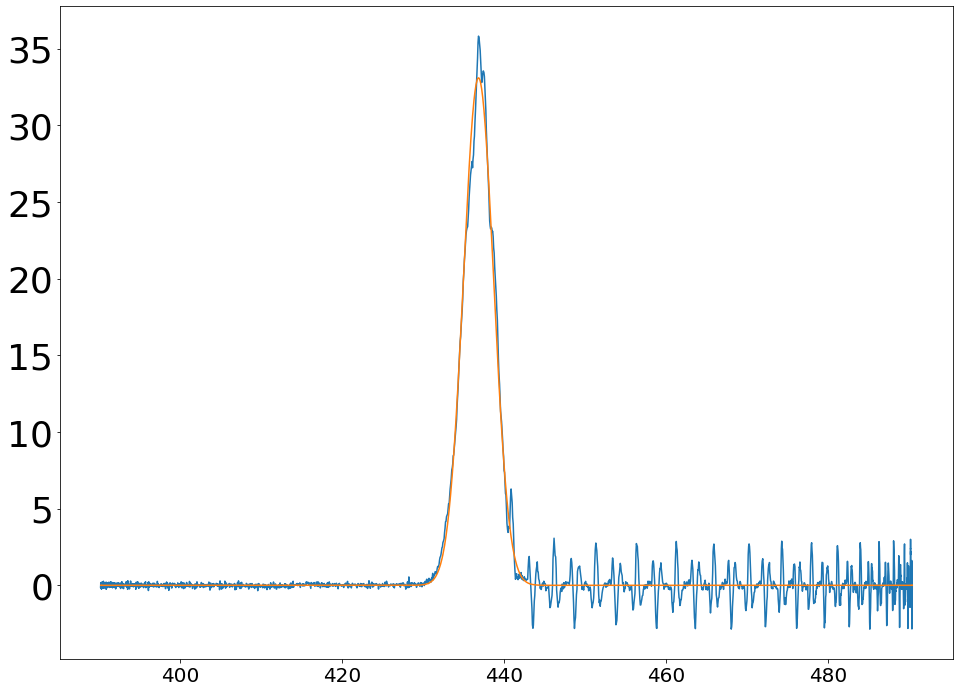

 33%|███▎      | 2/6 [00:00<00:00,  4.99it/s]

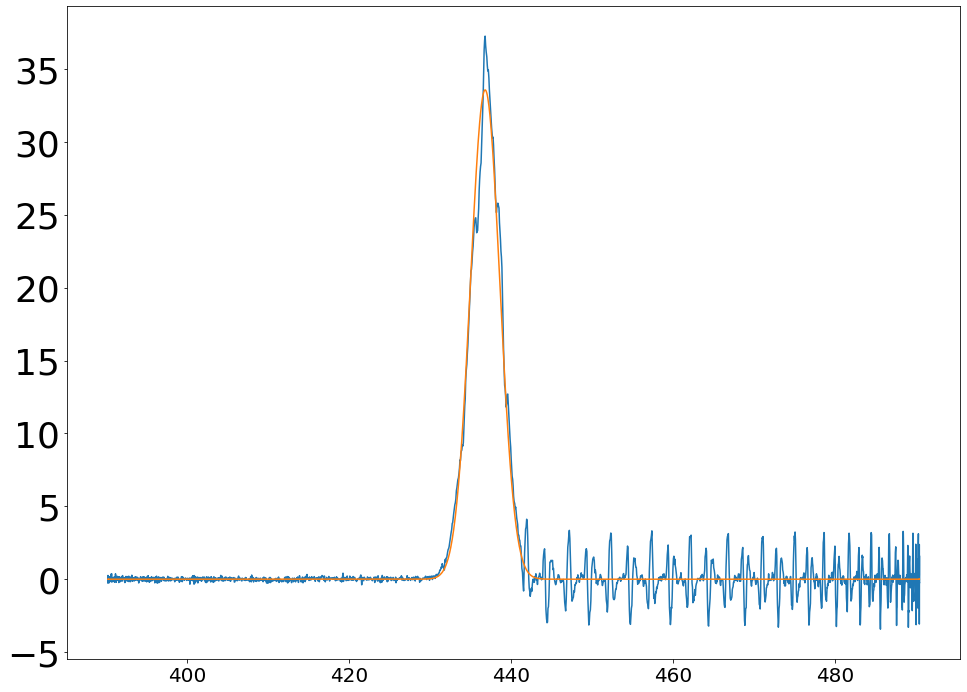

 50%|█████     | 3/6 [00:00<00:00,  5.02it/s]

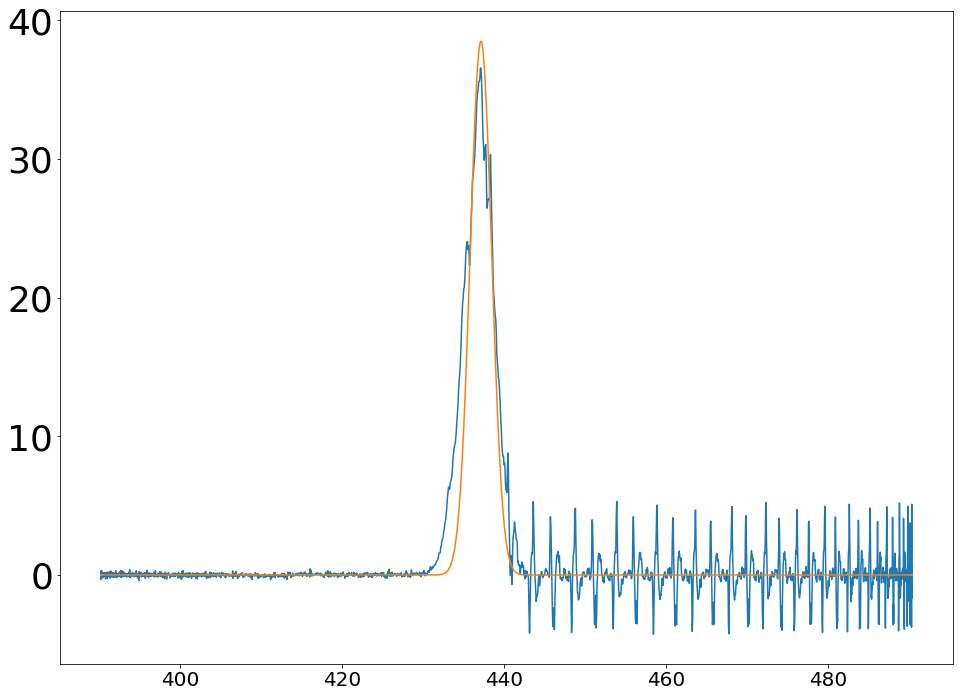

 67%|██████▋   | 4/6 [00:00<00:00,  5.17it/s]

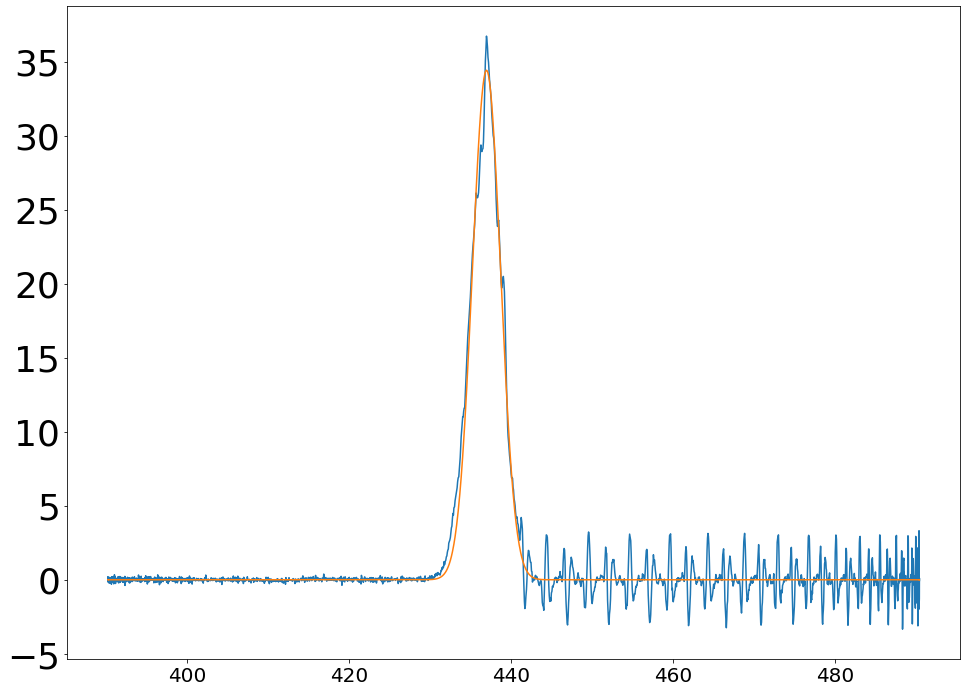

 83%|████████▎ | 5/6 [00:01<00:00,  4.64it/s]

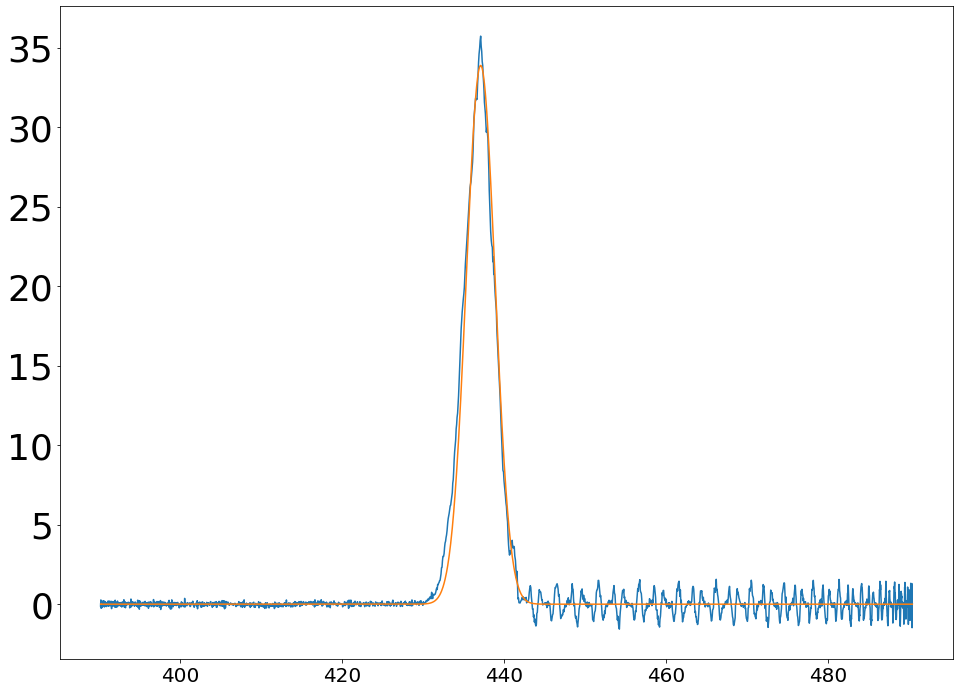

100%|██████████| 6/6 [00:01<00:00,  4.69it/s]

133657610.28759786 1811755.128839255 437.11387714316385 -3.544986638127858


In [293]:
avg_rng=1
up_or_low="up"
x = extract_waist_data(df_2,up_or_low=up_or_low,axis="Y",detector="SPIN",avg_rng=avg_rng,sub_sample=False,plot=True,logscale=False,save=False)


In [284]:
np.mean(x[2])

437.06338473541473

In [285]:
np.std(x[2])

0.1602705529177474

In [287]:
np.mean(x[2])

437.1212618181762

In [288]:
np.std(x[2])

0.2556238084728577

In [290]:
np.mean(x[2])

437.30347255909425

In [291]:
np.std(x[2])

0.227427632486586

In [294]:
np.mean(x[2])

437.021244382001

In [295]:
np.std(x[2])

0.16461301775069376